In [1]:
import numpy as np
import glob
import warnings
import datetime
import scipy.stats
import matplotlib.pyplot as plt
import os
import cdsapi
import xarray as xr
import xskillscore as xs
import pandas as pd
import xesmf as xesmf
import operator

In [2]:
def global_average(dataArray,latstr,lonstr):
    #Compute the latitude weighted average over the globe
    #datout = dataArray.where((dataArray[latstr] > 40.5) & (dataArray[latstr] < 50.5) &
    #                        (dataArray[lonstr] > 235.5) & (dataArray[lonstr] < 253.5),drop=True)
    weights = np.cos(np.deg2rad(dataArray[latstr]))
    weights.name = 'weights'
    datout_weighted = dataArray.weighted(weights).mean(dim=[latstr,lonstr],skipna=True)
    return datout_weighted

def pnw_average(dataArray,latstr,lonstr):
    #Compute the latitude weighted average over the PNW
    datout = dataArray.where((dataArray[latstr] > 40.5) & (dataArray[latstr] < 50.5) &
                            (dataArray[lonstr] > 235.5) & (dataArray[lonstr] < 253.5),drop=True)
    weights = np.cos(np.deg2rad(datout[latstr]))
    weights.name = 'weights'
    datout_weighted = datout.weighted(weights).mean(dim=[latstr,lonstr],skipna=True)
    return datout_weighted

In [3]:
def coordnames(nci):
    if 'latitude' in list(nci.variables):
        latstr = 'latitude'
    elif 'lat' in list(nci.variables):
        latstr = 'lat'
    elif 'nav_lat' in list(nci.variables):
        latstr = 'nav_lat'

    if 'longitude' in list(nci.variables):
        lonstr = 'longitude'
    elif 'lon' in list(nci.variables):
        lonstr = 'lon'
    elif 'nav_lon' in list(nci.variables):
        lonstr = 'nav_lon'

    if 'lat' in list(nci.dims):
        latdim = 'lat'
        londim = 'lon'
    elif 'latitude' in list(nci.dims):
        latdim = 'latitude'
        londim = 'longitude'
    elif 'nav_lat' in list(nci.dims):
        latdim = 'nav_lat'
        londim = 'nav_lon'
    elif 'x' in list(nci.dims):
        latdim = 'y'
        londim = 'x'
    else:
        latdim = 'j'
        londim = 'i'
    return latstr,lonstr,latdim,londim

In [4]:
def fixlons(nci,latdim,londim,lonstr):
    lonarray = np.zeros(nci[lonstr].shape)
    ndim = lonarray.ndim
    if ndim == 2:
        if float(nci[lonstr].min()) < -1.:
            for i in range(nci[lonstr].shape[0]):
                for j in range(nci[lonstr].shape[1]):
                    if float(nci[lonstr][i,j]) < 0.:
                        lonarray[i,j] = nci[lonstr][i,j].data + 360.
                    else:
                        lonarray[i,j] = nci[lonstr][i,j].data
            nci[lonstr] = ([latdim, londim], lonarray)
    elif ndim == 1:
        if float(nci[lonstr].min()) < -1.:
            for i in range(nci[lonstr].shape[0]):
                if float(nci[lonstr][i]) < 0.:
                    lonarray[i] = nci[lonstr][i].data + 360.
                else:
                    lonarray[i] = nci[lonstr][i].data
            nci[lonstr] = ([londim], lonarray)
    return nci

In [5]:
def regrid_with_nan(data,regridder,C=10.):
    data = data + C
    data_rg = regridder(data)
    data_rg[data_rg==0.0] = np.nan
    data_rg = data_rg - C
    return data_rg

In [6]:
def compute_trend_global(nci):
    if 'ens' in nci.variables:
        nens = len(nci['ens'])
    else:
        nens = 1
    month_length = nci.time.dt.days_in_month
    tmp = (nci['pr']*month_length)/10

    p = global_average(tmp,'lat','lon')
    p = p.groupby('time.year').sum(dim='time',skipna=False)
    t = global_average(nci['tas'],'lat','lon')
    t = t.groupby('time.year').mean(dim='time')
    ptmp = xs.linslope(p['year'],p,dim='year',skipna=False)*100
    ttmp = xs.linslope(t['year'],t,dim='year',skipna=False)*100
    ptrend = np.nanmean(ptmp)
    ttrend = np.nanmean(ttmp)
    
    return ptrend,ttrend,ptmp

def compute_trend_pnw(nci):
    if 'ens' in nci.variables:
        nens = len(nci['ens'])
    else:
        nens = 1
    month_length = nci.time.dt.days_in_month
    tmp = (nci['pr']*month_length)/10

    p = pnw_average(tmp,'lat','lon')
    p = p.groupby('time.year').sum(dim='time',skipna=False)
    t = pnw_average(nci['tas'],'lat','lon')
    t = t.groupby('time.year').mean(dim='time')
    ptmp = xs.linslope(p['year'],p,dim='year',skipna=False)*100
    ttmp = xs.linslope(t['year'],t,dim='year',skipna=False)*100
    ptrend = np.nanmean(ptmp)
    ttrend = np.nanmean(ttmp)
    
    return ptrend,ttrend,ptmp

In [7]:
def seasonal_avg_vars(nci,ncir,model,latstr,lonstr,obs):
    years = list(nci.groupby('time.year').groups)
    nyr = len(years)
    seaskeys = ['DJF','MAM','JJA','SON']
    drs = {}
    if obs == False:
        ens = list(nci['ens'])
        nens = len(ens)
    for seas in seaskeys:
        drs[seas] = {}
    for iy in range(nyr-1):
        drs['DJF'][iy] = slice(str(years[iy])+'-12-01',str(years[iy+1])+'-02-28')
        drs['MAM'][iy] = slice(str(years[iy+1])+'-03-01',str(years[iy+1])+'-05-30')
        drs['JJA'][iy] = slice(str(years[iy+1])+'-06-01',str(years[iy+1])+'-08-30')
        drs['SON'][iy] = slice(str(years[iy+1])+'-09-01',str(years[iy+1])+'-11-30')
    if obs==False:
        ncir['pranom'] = ncir['pr'].groupby('time.month') - ncir['pr'].groupby('time.month').mean(dim='time')
        ncir['tasanom'] = ncir['tas'].groupby('time.month') - ncir['tas'].groupby('time.month').mean(dim='time')
    elif obs==True:
        nci['pranom'] = nci['pr'].groupby('time.month') - nci['pr'].groupby('time.month').mean(dim='time')
        nci['tasanom'] = nci['tas'].groupby('time.month') - nci['tas'].groupby('time.month').mean(dim='time')
    outvars = {}
    eli = {}
    pr = {}
    pranom = {}
    tas = {}
    tasanom = {}
    n34 = {}
    if obs == False:
        for seas in seaskeys:
            eli[seas] = np.zeros((nens,nyr-1))
            n34[seas] = np.zeros((nens,nyr-1))
            pr[seas]  = np.zeros((nens,nyr-1,len(ncir[latstr]),len(ncir[lonstr])))
            pranom[seas]  = np.zeros((nens,nyr-1,len(ncir[latstr]),len(ncir[lonstr])))
            tas[seas] = np.zeros((nens,nyr-1,len(ncir[latstr]),len(ncir[lonstr])))
            tasanom[seas] = np.zeros((nens,nyr-1,len(ncir[latstr]),len(ncir[lonstr])))

            for iy in range(nyr-1):
                eli[seas][:,iy]     = nci['eli'].sel(time=drs[seas][iy]).mean(dim='time').values
                n34[seas][:,iy]     = nci['n34'].sel(time=drs[seas][iy]).mean(dim='time').values
                pranom[seas][:,iy,:,:]  = ncir['pranom'].sel(time=drs[seas][iy]).where(ncir['mask']==1).mean(dim='time').values
                tasanom[seas][:,iy,:,:] = ncir['tasanom'].sel(time=drs[seas][iy]).where(ncir['mask']==1).mean(dim='time').values
                pr[seas][:,iy,:,:]      = ncir['pr'].sel(time=drs[seas][iy]).where(ncir['mask']==1).mean(dim='time').values
                tas[seas][:,iy,:,:]     = ncir['tas'].sel(time=drs[seas][iy]).where(ncir['mask']==1).mean(dim='time').values

            outvars[seas] = xr.Dataset(
                data_vars = dict(
                    eli=(['ens','time'], eli[seas]),
                    n34=(['ens','time'], n34[seas]),
                    pr=(['ens','time','lat','lon'],pr[seas]),
                    pranom=(['ens','time','lat','lon'],pranom[seas]),
                    tas=(['ens','time','lat','lon'],tas[seas]),
                    tasanom=(['ens','time','lat','lon'],tasanom[seas]),
                ),
                coords = dict(
                    ens = (['ens'], nci['ens'].data),
                    time = pd.date_range(str(years[0]+1)+'-01-01', periods=nyr-1, freq='AS'),
                    lat = (['lat'],ncir[latstr].data),
                    lon = (['lon'],ncir[lonstr].data),
                ),
                attrs=dict(description= seas + ' average variables from: ' + model),
            )
    elif obs == True:
        for seas in seaskeys:
            eli[seas] = np.zeros(nyr-1)
            n34[seas] = np.zeros(nyr-1)
            pr[seas]  = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            pranom[seas]  = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tas[seas] = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tasanom[seas] = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))

            for iy in range(nyr-1):
                eli[seas][iy]           = nci['eli'].sel(time=drs[seas][iy]).mean(dim='time').values
                n34[seas][iy]           = nci['n34'].sel(time=drs[seas][iy]).mean(dim='time').values
                pranom[seas][iy,:,:]    = nci['pranom'].sel(time=drs[seas][iy]).mean(dim='time').values
                tasanom[seas][iy,:,:]   = nci['tasanom'].sel(time=drs[seas][iy]).mean(dim='time').values
                pr[seas][iy,:,:]        = nci['pr'].sel(time=drs[seas][iy]).mean(dim='time').values
                tas[seas][iy,:,:]       = nci['tas'].sel(time=drs[seas][iy]).mean(dim='time').values

            outvars[seas] = xr.Dataset(
                data_vars = dict(
                    eli=(['time'], eli[seas]),
                    n34=(['time'], n34[seas]),
                    pr=(['time','lat','lon'],pr[seas]),
                    pranom=(['time','lat','lon'],pranom[seas]),
                    tas=(['time','lat','lon'],tas[seas]),
                    tasanom=(['time','lat','lon'],tasanom[seas]),
                ),
                coords = dict(
                    time = pd.date_range(str(years[0]+1)+'-01-01', periods=nyr-1, freq='AS'),
                    lat = (['lat'],nci[latstr].data),
                    lon = (['lon'],nci[lonstr].data),
                ),
                attrs=dict(description= seas + ' average variables from: ' + model),
            )
    return outvars

def seasonal_avg_vars_pnw(nci,model,latstr,lonstr,obs):
    years = list(nci.groupby('time.year').groups)
    nyr = len(years)
    seaskeys = ['DJF','MAM','JJA','SON']
    drs = {}
    if obs == False:
        ens = list(nci['ens'])
        nens = len(ens)
    for seas in seaskeys:
        drs[seas] = {}
    for iy in range(nyr-1):
        drs['DJF'][iy] = slice(str(years[iy])+'-12-01',str(years[iy+1])+'-02-28')
        drs['MAM'][iy] = slice(str(years[iy+1])+'-03-01',str(years[iy+1])+'-05-30')
        drs['JJA'][iy] = slice(str(years[iy+1])+'-06-01',str(years[iy+1])+'-08-30')
        drs['SON'][iy] = slice(str(years[iy+1])+'-09-01',str(years[iy+1])+'-11-30')

    nci['pranom'] = nci['pr'].groupby('time.month') - nci['pr'].groupby('time.month').mean(dim='time')
    nci['tasanom'] = nci['tas'].groupby('time.month') - nci['tas'].groupby('time.month').mean(dim='time')
    outvars = {}
    eli = {}
    pr = {}
    pranom = {}
    tas = {}
    tasanom = {}
    n34 = {}
    if obs == False:
        for seas in seaskeys:
            eli[seas] = np.zeros((nens,nyr-1))
            n34[seas] = np.zeros((nens,nyr-1))
            pr[seas]  = np.zeros((nens,nyr-1,len(nci[latstr]),len(nci[lonstr])))
            pranom[seas]  = np.zeros((nens,nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tas[seas] = np.zeros((nens,nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tasanom[seas] = np.zeros((nens,nyr-1,len(nci[latstr]),len(nci[lonstr])))

            for iy in range(nyr-1):
                eli[seas][:,iy]     = nci['eli'].sel(time=drs[seas][iy]).mean(dim='time').values
                n34[seas][:,iy]     = nci['n34'].sel(time=drs[seas][iy]).mean(dim='time').values
                pranom[seas][:,iy,:,:]  = nci['pranom'].sel(time=drs[seas][iy]).mean(dim='time').values
                tasanom[seas][:,iy,:,:] = nci['tasanom'].sel(time=drs[seas][iy]).mean(dim='time').values
                pr[seas][:,iy,:,:]      = nci['pr'].sel(time=drs[seas][iy]).mean(dim='time').values
                tas[seas][:,iy,:,:]     = nci['tas'].sel(time=drs[seas][iy]).mean(dim='time').values

            outvars[seas] = xr.Dataset(
                data_vars = dict(
                    eli=(['ens','time'], eli[seas]),
                    n34=(['ens','time'], n34[seas]),
                    pr=(['ens','time','lat','lon'],pr[seas]),
                    pranom=(['ens','time','lat','lon'],pranom[seas]),
                    tas=(['ens','time','lat','lon'],tas[seas]),
                    tasanom=(['ens','time','lat','lon'],tasanom[seas]),
                ),
                coords = dict(
                    ens = (['ens'], nci['ens'].data),
                    time = pd.date_range(str(years[0]+1)+'-01-01', periods=nyr-1, freq='AS'),
                    lat = (['lat'],nci[latstr].data),
                    lon = (['lon'],nci[lonstr].data),
                ),
                attrs=dict(description= seas + ' average variables from: ' + model),
            )
    elif obs == True:
        for seas in seaskeys:
            eli[seas] = np.zeros(nyr-1)
            n34[seas] = np.zeros(nyr-1)
            pr[seas]  = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            pranom[seas]  = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tas[seas] = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))
            tasanom[seas] = np.zeros((nyr-1,len(nci[latstr]),len(nci[lonstr])))

            for iy in range(nyr-1):
                eli[seas][iy]           = nci['eli'].sel(time=drs[seas][iy]).mean(dim='time').values
                n34[seas][iy]           = nci['n34'].sel(time=drs[seas][iy]).mean(dim='time').values
                pranom[seas][iy,:,:]    = nci['pranom'].sel(time=drs[seas][iy]).mean(dim='time').values
                tasanom[seas][iy,:,:]   = nci['tasanom'].sel(time=drs[seas][iy]).mean(dim='time').values
                pr[seas][iy,:,:]        = nci['pr'].sel(time=drs[seas][iy]).mean(dim='time').values
                tas[seas][iy,:,:]       = nci['tas'].sel(time=drs[seas][iy]).mean(dim='time').values

            outvars[seas] = xr.Dataset(
                data_vars = dict(
                    eli=(['time'], eli[seas]),
                    n34=(['time'], n34[seas]),
                    pr=(['time','lat','lon'],pr[seas]),
                    pranom=(['time','lat','lon'],pranom[seas]),
                    tas=(['time','lat','lon'],tas[seas]),
                    tasanom=(['time','lat','lon'],tasanom[seas]),
                ),
                coords = dict(
                    time = pd.date_range(str(years[0]+1)+'-01-01', periods=nyr-1, freq='AS'),
                    lat = (['lat'],nci[latstr].data),
                    lon = (['lon'],nci[lonstr].data),
                ),
                attrs=dict(description= seas + ' average variables from: ' + model),
            )
    return outvars

In [8]:
# Setting up CMIP6 datasets
diri='/glade/u/home/nlybarger/scratch/data/climate_data/cmip6/postproc/'
filis = sorted(glob.glob(diri + '*historical.nc'))
nfil = len(filis)
models = ['0']*nfil
for i in range(nfil):
    models[i] = filis[i].split('/')[-1].split('.')[0]


In [10]:
odiri = '/glade/work/nlybarger/data/OBS/'
odsets = ['CRU','ERA-5','UDel']
fnames = ['cru','era5','udel']
obs = {}
oyears = {}
for i in range(len(odsets)):
    obs[odsets[i]] = xr.open_dataset(odiri + odsets[i] + '/1deg.' + fnames[i] + '.global.p.t.nc',engine='netcdf4')
    oyears[odsets[i]] = list(obs[odsets[i]].groupby('time.year').groups)

n34f = '/glade/work/nlybarger/data/clim_indices/nino34.1870-2021.txt'
fp = open(n34f,'r')
n34o = np.genfromtxt(fp,delimiter=',',usecols=np.arange(1,13),dtype='f4')
n34o = np.reshape(n34o[30:150,:],(120*12))
fp.close()

elifi = '/glade/work/nlybarger/data/clim_indices/ELI_ERSSTv5_1854.01-2019.12.csv'
fp = open(elifi,'r')
elio = np.genfromtxt(fp,delimiter=',',usecols=np.arange(47,167),dtype='f4',skip_header=1)
elio = np.transpose(elio)
elio = np.reshape(elio,(120*12,))
fp.close()

indy = xr.Dataset(
        data_vars = dict(
            eli=(['time'], elio),
            n34=(['time'], n34o),
        ),
        coords = dict(
            time=(['time'], pd.date_range('1900-01-01','2019-12-31',freq='MS')),
        ),
)

oseasvars = {}
for dset in odsets:
    print(dset)
    if dset in ['CRU','ERA-5','GMET','PRISM']:
        oyears[dset] = oyears[dset][:-2]

    obs[dset] = obs[dset].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31'))
    obs[dset]['n34'] = (['time'],indy['n34'].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31')).data)
    obs[dset]['eli'] = (['time'],indy['eli'].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31')).data)
    oseasvars[dset] = seasonal_avg_vars(obs[dset],_,'obs','lat','lon',True)

CRU
ERA-5
UDel


In [11]:
dmeanto = {}
dsampto = {}
dmeanpo = {}
dsamppo = {}
#ddjf_corrs_obs = {}
dptrendo = {}
dttrendo = {}

for dset in odsets:
    nyr = len(oyears[dset])
    ## Obs metrics
    # Mean-T
    gbto = global_average(obs[dset]['tas'],'lat','lon')
    dmeanto[dset] = global_average(obs[dset]['tas'].groupby('time.year').mean(dim='time',skipna=True),'lat','lon')
    dmeanto[dset] = dmeanto[dset].mean()

    # Seasonal Amplitude-T
    it=0
    dsampto[dset] = np.zeros(nyr)
    for year in oyears[dset]:
        tmp = gbto.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31'))
        dsampto[dset][it] = tmp.max()-tmp.min()
        it+=1
    dsampto[dset] = dsampto[dset].mean()

    # Mean-P
    tmp = obs[dset]['pr']/10
    gbpo = global_average(tmp,'lat','lon')
    dmeanpo[dset] = global_average(tmp.groupby('time.year').sum(dim='time',skipna=False),'lat','lon')
    dmeanpo[dset] = dmeanpo[dset].mean()

    # Seasonal Amplitude-P
    it=0
    dsamppo[dset] = np.zeros(nyr)
    for year in oyears[dset]:
        tmp = gbpo.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31'))
        dsamppo[dset][it] = tmp.max()-tmp.min()
        it+=1
    dsamppo[dset] = dsamppo[dset].mean()

    # Nino3.4/ELI - variable Anomalies DJF
    #pnwlat = slice(35,55)
    #pnwlon = slice(230,258)
    # epnwlat = slice(20,60)
    # epnwlon = slice(195,260)

    # ddjf_corrs_obs[dset] = {}
    # ddjf_corrs_obs[dset]['n34pr'] = xs.pearson_r(oseasvars[dset]['DJF']['n34'],oseasvars[dset]['DJF']['pranom'],dim='time')
    # ddjf_corrs_obs[dset]['elipr'] = xs.pearson_r(oseasvars[dset]['DJF']['eli'],oseasvars[dset]['DJF']['pranom'],dim='time')
    # ddjf_corrs_obs[dset]['n34t'] = xs.pearson_r(oseasvars[dset]['DJF']['n34'],oseasvars[dset]['DJF']['tasanom'],dim='time')
    # ddjf_corrs_obs[dset]['elit'] = xs.pearson_r(oseasvars[dset]['DJF']['eli'],oseasvars[dset]['DJF']['tasanom'],dim='time')
    # djf_corrs_obs['n34z'] = xs.pearson_r(seasvars_obs['DJF']['n34'],seasvars_obs['DJF']['gphanom'].sel(lat=epnwlat,lon=epnwlon,drop=True),dim='time')
    # djf_corrs_obs['eliz'] = xs.pearson_r(seasvars_obs['DJF']['eli'],seasvars_obs['DJF']['gphanom'].sel(lat=epnwlat,lon=epnwlon,drop=True),dim='time')
    if dset in ['CRU','UDel']:
        tmp = obs[dset]['pr'].sel(time=slice('1901-01-01','2014-12-30'),drop=True)/10
        ptmpo = global_average(tmp.groupby('time.year').sum(dim='time',skipna=False),'lat','lon')
        ttmpo = global_average((obs[dset]['tas'].sel(time=slice('1901-01-01','2014-12-30'),drop=True)).groupby('time.year').mean(dim='time',skipna=True),'lat','lon')

        dptrendo[dset] = (xs.linslope(ptmpo['year'], ptmpo, dim='year')*100).data
        dttrendo[dset] = (xs.linslope(ttmpo['year'], ttmpo, dim='year')*100).data

dummy1deg = xr.Dataset(
        data_vars = dict(
    ),
    coords = dict(
        lon = (['lon'], np.arange(1,361)),
        lat = (['lat'], np.arange(-90,91)),
    ),
)

In [12]:
# dco = {}
meanto = np.zeros(1)
sampto = np.zeros(1)
meanpo = np.zeros(1)
samppo = np.zeros(1)

ptrendo = np.zeros(1)
ttrendo = np.zeros(1)

nd = len(odsets)
ndt=0
# for met in ['n34pr','elipr','n34t','elit']:
#     dco[met] = np.zeros(1)
for dset in odsets:
    meanto = meanto + dmeanto[dset].data
    sampto = sampto + dsampto[dset].data
    meanpo = meanpo + dmeanpo[dset].data
    samppo = samppo + dsamppo[dset].data
    # for met in ['n34pr','elipr','n34t','elit']:
    #     dco[met] = dco[met] + ddjf_corrs_obs[dset][met].data
    if dset in ['CRU','UDel']:
        ndt += 1
        ptrendo = ptrendo + dptrendo[dset]
        ttrendo = ttrendo + dttrendo[dset]

meanto = meanto/nd
sampto = sampto/nd
meanpo = meanpo/nd
samppo = samppo/nd
ptrendo = ptrendo/ndt
ttrendo = ttrendo/ndt
# for met in ['n34pr','elipr','n34t','elit']:
#     dco[met] = dco[met]/nd

# seasvars_obs = {}
# avgr = {}
# avgr['DJF'] = [1,2,12]
# avgr['MAM'] = [3,4,5]
# avgr['JJA'] = [6,7,8]
# avgr['SON'] = [9,10,11]

# dseasvars_obs = {}
# dseas_scorrs = {}
# dseas_stdevs = {}
# for seas in ['DJF','MAM','JJA','SON']:
#     seasvars_obs[seas] = {}
#     dseasvars_obs[seas] = {}

#     i = 0
#     for dset in odsets:
#         dseasvars_obs[seas][dset] = {}
#         dseasvars_obs[seas][dset]['tas'] = obs[dset]['tas'].groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')
#         dseasvars_obs[seas][dset]['pr'] = obs[dset]['pr'].groupby('time.month').mean(dim='time').sel(month=avgr[seas],drop=True).mean(dim='month')
#         if i==0:
#             seasvars_obs[seas]['tas'] = dseasvars_obs[seas][dset]['tas']
#             seasvars_obs[seas]['pr'] = dseasvars_obs[seas][dset]['pr']
#             #seasvars_obs[seas]['tas'] = oseasvars[dset][seas]['tas'].sel(lat=pnwlat,lon=pnwlon).mean(dim='time')
#             #seasvars_obs[seas]['pr'] = oseasvars[dset][seas]['pr'].sel(lat=pnwlat,lon=pnwlon).mean(dim='time')
#             i += 1
#         else:
#             seasvars_obs[seas]['tas'] = seasvars_obs[seas]['tas'] + dseasvars_obs[seas][dset]['tas']
#             seasvars_obs[seas]['pr'] = seasvars_obs[seas]['pr'] + dseasvars_obs[seas][dset]['pr']
#             #seasvars_obs[seas]['tas'] = seasvars_obs[seas]['tas'] + oseasvars[dset][seas]['tas'].sel(lat=pnwlat,lon=pnwlon).mean(dim='time')
#             #seasvars_obs[seas]['pr'] = seasvars_obs[seas]['pr'] + oseasvars[dset][seas]['pr'].sel(lat=pnwlat,lon=pnwlon).mean(dim='time')
#     seasvars_obs[seas]['tas'] = seasvars_obs[seas]['tas']/nd
#     seasvars_obs[seas]['pr'] = seasvars_obs[seas]['pr']/nd

#     dseas_scorrs[seas] = np.full((len(odsets),len(odsets),2),np.nan)
#     dseas_stdevs[seas] = np.full((len(odsets),len(odsets),2),np.nan)
#     for i in range(len(odsets)):
#         dset = odsets[i]
#         for j in range(len(odsets)):
#             dset2 = odsets[j]
#             if j==i:
#                 continue
#             else:
#                 dseas_scorrs[seas][i,j,0] = xs.pearson_r(dseasvars_obs[seas][dset]['tas'],dseasvars_obs[seas][dset2]['tas'],dim=['lat','lon'],skipna=True).data
#                 dseas_scorrs[seas][i,j,1] = xs.pearson_r(dseasvars_obs[seas][dset]['pr'],dseasvars_obs[seas][dset2]['pr'],dim=['lat','lon'],skipna=True).data
#                 dseas_stdevs[seas][i,j,0] = np.nanstd(dseasvars_obs[seas][dset]['tas'].data)/np.nanstd(dseasvars_obs[seas][dset2]['tas'].data)
#                 dseas_stdevs[seas][i,j,1] = np.nanstd(dseasvars_obs[seas][dset]['pr'].data)/np.nanstd(dseasvars_obs[seas][dset2]['pr'].data)
#     dseas_scorrs[seas] = np.nanmean(dseas_scorrs[seas],axis=1)
#     dseas_stdevs[seas] = np.nanmean(dseas_stdevs[seas],axis=1)
# djf_corrs_obs = xr.Dataset(
#         data_vars = dict(
#         n34pr = (['lat','lon'], dco['n34pr']),
#         elipr = (['lat','lon'], dco['elipr']),
#         n34t = (['lat','lon'], dco['n34t']),
#         elit = (['lat','lon'], dco['elit']),
#     ),
#     coords = dict(
#         lon = (['lon'], seasvars_obs['DJF']['tas']['lon'].data),
#         lat = (['lat'], seasvars_obs['DJF']['tas']['lat'].data),
#     ),
# )
# ensomets = ['n34pr','elipr','n34t','elit']
# obs_enso_corrs = {}
# for imet in range(4):
#     met = ensomets[imet]
#     obs_enso_corrs[met] = np.full((nd,nd),np.nan)
#     for i in range(len(odsets)):
#         dset = odsets[i]
#         for j in range(len(odsets)):
#             dset2 = odsets[j]
#             if i==j:
#                 continue
#             else:
#                 obs_enso_corrs[met][i,j] = xs.pearson_r(ddjf_corrs_obs[dset][met],ddjf_corrs_obs[dset2][met],skipna=True).data
#     obs_enso_corrs[met] = np.nanmean(obs_enso_corrs[met],axis=1)

In [18]:
odiri = '/glade/work/nlybarger/data/OBS/'
odsets = ['CRU','ERA-5','GMET','UDel','Livneh','PRISM']
fnames = ['cru','era5','gmetensm','udel','livneh','prism',]
obs = {}
oyears = {}
for i in range(len(odsets)):
    obs[odsets[i]] = xr.open_dataset(odiri + odsets[i] + '/1deg.' + fnames[i] + '.wconus.p.t.nc',engine='netcdf4')
    oyears[odsets[i]] = list(obs[odsets[i]].groupby('time.year').groups)

n34f = '/glade/work/nlybarger/data/clim_indices/nino34.1870-2021.txt'
fp = open(n34f,'r')
n34o = np.genfromtxt(fp,delimiter=',',usecols=np.arange(1,13),dtype='f4')
n34o = np.reshape(n34o[30:150,:],(120*12))
fp.close()

elifi = '/glade/work/nlybarger/data/clim_indices/ELI_ERSSTv5_1854.01-2019.12.csv'
fp = open(elifi,'r')
elio = np.genfromtxt(fp,delimiter=',',usecols=np.arange(47,167),dtype='f4',skip_header=1)
elio = np.transpose(elio)
elio = np.reshape(elio,(120*12,))
fp.close()

indy = xr.Dataset(
        data_vars = dict(
            eli=(['time'], elio),
            n34=(['time'], n34o),
        ),
        coords = dict(
            time=(['time'], pd.date_range('1900-01-01','2019-12-31',freq='MS')),
        ),
)

oseasvars = {}
for dset in odsets:
    print(dset)
    if dset in ['CRU','ERA-5','GMET','PRISM']:
        oyears[dset] = oyears[dset][:-2]

    obs[dset] = obs[dset].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31'))
    obs[dset]['n34'] = (['time'],indy['n34'].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31')).data)
    obs[dset]['eli'] = (['time'],indy['eli'].sel(time=slice(str(oyears[dset][0])+'-01-01',str(oyears[dset][-1])+'-12-31')).data)
    oseasvars[dset] = seasonal_avg_vars_pnw(obs[dset],'obs','lat','lon',True)

CRU
ERA-5
GMET
UDel
Livneh
PRISM


In [19]:
pdmeanto = {}
pdsampto = {}
pdmeanpo = {}
pdsamppo = {}
pdptrendo = {}
pdttrendo = {}

for dset in odsets:
    nyr = len(oyears[dset])
    ## Obs metrics
    # Mean-T
    gbto = pnw_average(obs[dset]['tas'],'lat','lon')
    pdmeanto[dset] = pnw_average(obs[dset]['tas'].groupby('time.year').mean(dim='time',skipna=True),'lat','lon')
    pdmeanto[dset] = pdmeanto[dset].mean()

    # Seasonal Amplitude-T
    it=0
    pdsampto[dset] = np.zeros(nyr)
    for year in oyears[dset]:
        tmp = gbto.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31'))
        pdsampto[dset][it] = tmp.max()-tmp.min()
        it+=1
    pdsampto[dset] = pdsampto[dset].mean()

    # Mean-P
    tmp = obs[dset]['pr']/10
    gbpo = pnw_average(tmp,'lat','lon')
    pdmeanpo[dset] = pnw_average(tmp.groupby('time.year').sum(dim='time',skipna=False),'lat','lon')
    pdmeanpo[dset] = pdmeanpo[dset].mean()

    # Seasonal Amplitude-P
    it=0
    pdsamppo[dset] = np.zeros(nyr)
    for year in oyears[dset]:
        tmp = gbpo.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31'))
        pdsamppo[dset][it] = tmp.max()-tmp.min()
        it+=1
    pdsamppo[dset] = pdsamppo[dset].mean()

    # Nino3.4/ELI - variable Anomalies DJF
    pnwlat = slice(35,55)
    pnwlon = slice(230,258)

    if dset in ['CRU','UDel']:
        tmp = obs[dset]['pr'].sel(time=slice('1901-01-01','2014-12-30'),drop=True)/10
        ptmpo = pnw_average(tmp.groupby('time.year').sum(dim='time',skipna=False),'lat','lon')
        ttmpo = pnw_average((obs[dset]['tas'].sel(time=slice('1901-01-01','2014-12-30'),drop=True)).groupby('time.year').mean(dim='time',skipna=True),'lat','lon')

        pdptrendo[dset] = (xs.linslope(ptmpo['year'], ptmpo, dim='year')*100).data
        pdttrendo[dset] = (xs.linslope(ttmpo['year'], ttmpo, dim='year')*100).data


In [20]:

pmeanto = np.zeros(1)
psampto = np.zeros(1)
pmeanpo = np.zeros(1)
psamppo = np.zeros(1)

pptrendo = np.zeros(1)
pttrendo = np.zeros(1)

nd = len(odsets)
ndt=0
for dset in odsets:
    pmeanto = pmeanto + pdmeanto[dset].data
    psampto = psampto + pdsampto[dset].data
    pmeanpo = pmeanpo + pdmeanpo[dset].data
    psamppo = psamppo + pdsamppo[dset].data
    if dset in ['CRU','UDel']:
        ndt += 1
        pptrendo = pptrendo + pdptrendo[dset]
        pttrendo = pttrendo + pdttrendo[dset]

pmeanto = pmeanto/nd
psampto = psampto/nd
pmeanpo = pmeanpo/nd
psamppo = psamppo/nd
pptrendo = pptrendo/ndt
pttrendo = pttrendo/ndt



### Metric Checklist
#### Done
- MeanT
- MeanP
- SeasonAmpT
- SeasonAmpP
- DJF_ELI_med_bias
- DJF_ELI_Levene
- SpaceCor_N34_P
- SpaceCor_ELI_P
- SpaceCor_N34_T
- SpaceCor_ELI_T
- SpaceCor_N34_Z200/Z500
- SpaceCor_ELI_Z200/Z500
- SpaceCor - MMMT
- SpaceCor - MMMP (expanded domain)
- SpaceSD - MMMT
- SpaceSD - MMMP (expanded domain)

In [21]:
if 'NorCPM1' in models:
    models.remove('NorCPM1')
if 'E3SM-1-1' in models:
    models.remove('E3SM-1-1')

In [22]:
diro = '/glade/work/nlybarger/data/hydromet/cmip6_metrics/global/'
metrics = {}
for mod in models:
    tmpfil = diro + mod + '.cmip6.historical.global_metrics.nc'
    if os.path.exists(tmpfil):
        metrics[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    else:
        print('no')
        continue
        
pnw_metrics = {}
for mod in models:
    tmpfil = '/glade/work/nlybarger/data/hydromet/cmip6_metrics/PNW/' + mod + '.cmip6.metrics.PNW.nc'
    if os.path.exists(tmpfil):
        pnw_metrics[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    else:
        print('no')
        continue
        
metrics['MCM-UA-1-0'] = metrics['MCM-UA-1-0'].isel(ens=[1])
pnw_metrics['MCM-UA-1-0'] = pnw_metrics['MCM-UA-1-0'].isel(ens=[1])

In [23]:
remmodels = ['CIESM','NorCPM1','KIOST-ESM']
for mod in remmodels:
    if mod in list(metrics.keys()):
        metrics.pop(mod)
models = list(metrics.keys())

In [24]:
len(models)

63

In [25]:
nmet = 52
nens = 72

nmod = len(models)
modmet = np.full((nmod,nmet,nens),np.nan)
errs = np.full((nmod,nmet,nens),np.nan)
for i in range(nmod):
# metrics here refers to global metrics, while
# pnw_metrics is PNW metrics

#    print(models[i])
## Mean-T, Mean-P, Seasonal Amplitude-T, Seasonal Amplitude-P
    nensmod = len(metrics[models[i]]['ens'])
    j=0
    modmet[i,j,:nensmod] = metrics[models[i]]['meant'] + meanto.item()
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-meanto.item())
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['meanp'] + meanpo.item()
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-meanpo.item())
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['ttrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-ttrendo)
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['ptrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-ptrendo)
    j+=1
## ELI - bias of the median and Levene's statistic
    modmet[i,j,:nensmod] = metrics[models[i]]['elimed']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-np.median(oseasvars['CRU']['DJF']['eli']))
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['levstat']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod])
    j+=1
## DJF Spatial Correlation with Obs for Nino3.4 and ELI for T and P
    modmet[i,j,:nensmod] = metrics[models[i]]['n34pr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['elipr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['n34t_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['elit_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Correlation for T and P with Obs
    modmet[i,j,:nensmod] = metrics[models[i]]['djf_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['mam_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['jja_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['son_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['djf_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['mam_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['jja_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['son_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Standard Deviation for T and P with Obs
    modmet[i,j,:nensmod] = metrics[models[i]]['djf_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['mam_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['jja_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['son_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['djf_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['mam_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['jja_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = metrics[models[i]]['son_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    
    # PNW metrics
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['meant']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pmeanto.item())
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['meanp']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pmeanpo.item())
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['sampt']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-psampto)
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['sampp']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-psamppo)
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['ttrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pttrendo)
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['ptrend']
    errs[i,j,:nensmod] = abs(modmet[i,j,:nensmod]-pptrendo)
    j+=1
## DJF Spatial Correlation with Obs for Nino3.4 and ELI for T and P
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['n34pr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['elipr_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['n34t_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['elit_rdjf']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Correlation for T and P with Obs
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['djf_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['mam_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['jja_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['son_t_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['djf_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['mam_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['jja_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['son_pr_r']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
## Seasonal Spatial Standard Deviation for T and P with Obs
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['djf_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['mam_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['jja_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['son_t_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['djf_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['mam_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['jja_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    j+=1
    modmet[i,j,:nensmod] = pnw_metrics[models[i]]['son_pr_sd']
    errs[i,j,:nensmod] = abs(1-modmet[i,j,:nensmod])
    
print(j+1)

52


In [26]:
nensmod = len(pnw_metrics[models[i]]['ens'])

In [31]:
# Computes relative errors for combined PNW + global metrics
relerrs = np.full((nmod,nmet,nens),np.nan)
for i in range(nmod):
    nensmod = nensmod = len(metrics[models[i]]['ens'])
    for j in range(nmet):
        for k in range(nensmod):
            relerrs[i,j,k] = (errs[i,j,k] - np.nanmin(errs[:,j,:]))/(np.nanmax(errs[:,j,:])-np.nanmin(errs[:,j,:]))
relerrtot = np.nansum(relerrs,axis=1)
relerrtot[relerrtot==0.] = np.nan
relerrtot = np.nanmean(relerrtot,axis=1)
relerrtotmin = np.nanmin(relerrtot)
relerrtot = relerrtot - relerrtotmin

a = np.array(relerrtot/max(relerrtot))
sortie = np.array(sorted(relerrtot/max(relerrtot)))
labs = ['0']*len(relerrtot)
indy = np.zeros(len(relerrtot),dtype=int)
for i in range(len(relerrtot)):
    indy[i] = np.where(a==sortie[i])[0][0]
    labs[i] = models[indy[i]]

In [ ]:
for i in range(nmod):
    print(models[indy[i]])

Text(0.5, 0, 'Models')

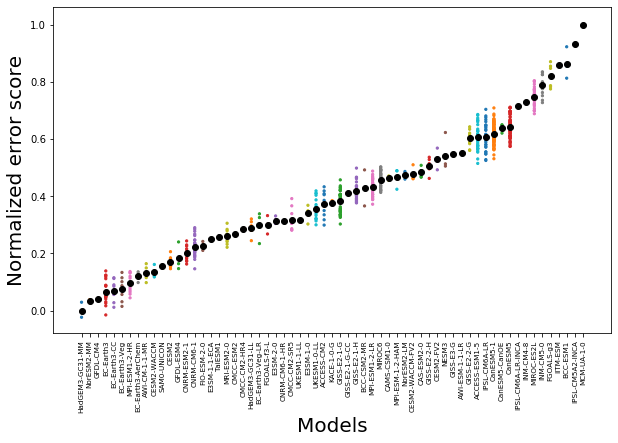

In [32]:
# Plots relative error scores for each model and ensemble member

diro = '/glade/work/nlybarger/data/hydromet/ESM_eval_semifinal_plots/final/'
plt.figure(figsize=(10,6))
plt.xticks(ticks=np.arange(nmod),labels=labs,rotation=90,fontsize=7.2)
x = np.arange(nmod)
for i in range(nmod):
    nensmod = len(metrics[models[indy[i]]]['ens'])
    plt.scatter(np.full((nensmod),i),(np.nansum(np.squeeze(relerrs[indy[i],:,:nensmod]),axis=0)-relerrtotmin)/max(relerrtot),sizes=np.full((nensmod),5))
plt.scatter(np.arange(nmod),sortie,c='k')
plt.ylabel('Normalized error score',fontsize=20)
plt.xlabel('Models',fontsize=20)
plt.savefig(diro + 'CMIP6_1900-2014.global-PNW.error_norm.png',dpi=450,bbox_inches='tight',facecolor='w')

In [14]:
ncissp245 = {}
for mod in models:
    tmpfil = diri + mod + '.ssp245.nc'
    if os.path.exists(tmpfil):
        ncissp245[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    else:
        continue
    
ncissp370 = {}
for mod in models:
    tmpfil = diri + mod + '.ssp370.nc'
    if os.path.exists(tmpfil):
        ncissp370[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    else:
        continue
for mod in ['CESM2-WACCM','NorESM2-LM']:
    ncissp370[mod] = ncissp370[mod].isel(ens=[0],drop=True)
    
ncissp585 = {}
for mod in models:
    tmpfil = diri + mod + '.ssp585.nc'
    if os.path.exists(tmpfil):
        ncissp585[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    else:
        continue

In [35]:
s_relerrtot=sorted(relerrtot)
# print(butt)
nmod=len(models)
culledmodels = ['0']*nmod
for i in range(nmod):
    j = np.where(relerrtot==s_relerrtot[i])[0][0]
    culledmodels[i] = models[j]

[0.0, 0.5887768821932884, 0.6949248952038278, 1.156251495650789, 1.2214091063230708, 1.3320026409457597, 1.6671831281956475, 2.0955081993674565, 2.2914794675353303, 2.3306923253191485, 2.7443792512399217, 2.9499698906267255, 3.2063291329911063, 3.488368986700566, 3.9082278869387572, 3.9689224896798034, 4.3916987260163545, 4.4908048211484495, 4.536802548848492, 4.677178449385371, 5.007288266810441, 5.070016966623209, 5.223318449375208, 5.246906682987083, 5.477194554536606, 5.4781916442069, 5.528066163788308, 5.5558420802379995, 5.9293348884377615, 6.225629365815669, 6.492975475789043, 6.593985912857823, 6.6648615167500065, 7.19150857839789, 7.310085870494628, 7.485446156098092, 7.53698023614524, 7.996807975302907, 8.097385976597696, 8.154463144276164, 8.30002269412634, 8.33651458246289, 8.430800671760771, 8.850063952841275, 9.221241142253145, 9.457509794216378, 9.572146300719101, 9.631039101077079, 10.515086634709402, 10.56534054938177, 10.603120504550205, 10.788514401381502, 11.1506507

In [46]:
# Compute global and PNW ptrend and ttrend

global_ptrends = {}
global_ttrends = {}
pnw_ptrends = {}
pnw_ttrends = {}

exps = ['hist','ssp245','ssp370','ssp585']
for exp in exps:
    global_ptrends[exp] = np.zeros(nmod)
    global_ttrends[exp] = np.zeros(nmod)
    pnw_ptrends[exp] = np.zeros(nmod)
    pnw_ttrends[exp] = np.zeros(nmod)

#for k in range(nmod):
j=0
for mod in culledmodels:
    for exp in exps:
        if exp == 'ssp245' and mod in ncissp245:
            ncitmp = ncissp245[mod]
            modexp = True
        elif exp == 'ssp370' and mod in ncissp370:
            ncitmp = ncissp370[mod]
            modexp = True
        elif exp == 'ssp585' and mod in ncissp585:
            ncitmp = ncissp585[mod]
            modexp = True
        else:
            modexp = False
        if modexp:
            regr = xesmf.Regridder(ncitmp,dummy1deg,method='bilinear',ignore_degenerate=True)
            ncitmp = regr(ncitmp)
            mask_array = 1 * np.ones((ncitmp.dims['lat'], ncitmp.dims['lon'])) * ~np.isnan(obs['CRU']['pr'].isel(time=0))
            ncitmp.coords['mask'] = (('lat', 'lon'), mask_array.data)
            global_ptrends[exp][j],global_ttrends[exp][j],_ = compute_trend_global(ncitmp.where(ncitmp['mask']==1))
            pnw_ptrends[exp][j],pnw_ttrends[exp][j],_ = compute_trend_pnw(ncitmp.where(ncitmp['mask']==1))
        else:
            global_ptrends[exp][j] = np.nan
            global_ttrends[exp][j] = np.nan
            pnw_ptrends[exp][j] = np.nan
            pnw_ttrends[exp][j] = np.nan

    global_ptrends['hist'][j] = np.nanmean(metrics[mod]['ptrend'])
    global_ttrends['hist'][j] = np.nanmean(metrics[mod]['ttrend'])
    pnw_ptrends['hist'][j] = np.nanmean(pnw_metrics[mod]['ptrend'])
    pnw_ttrends['hist'][j] = np.nanmean(pnw_metrics[mod]['ttrend'])
    j += 1

In [47]:
# The trends take a long time to compute, so save for later use
for exp in exps:
    np.save('/glade/u/home/nlybarger/scripts/python/hydromet/CMIP6.global.ptrend.'+exp+'.npy',global_ptrends[exp])
    np.save('/glade/u/home/nlybarger/scripts/python/hydromet/CMIP6.global.ttrend.'+exp+'.npy',global_ttrends[exp])
    np.save('/glade/u/home/nlybarger/scripts/python/hydromet/CMIP6.PNW.ptrend.'+exp+'.npy',pnw_ptrends[exp])
    np.save('/glade/u/home/nlybarger/scripts/python/hydromet/CMIP6.PNW.ttrend.'+exp+'.npy',pnw_ttrends[exp])

In [29]:
# Load the trends from file
exps = ['hist','ssp245','ssp370','ssp585']
global_ptrends = {}
global_ttrends = {}
pnw_ptrends = {}
pnw_ttrends = {}
for exp in exps:
    global_ptrends[exp] = np.load('/glade/u/home/nlybarger/scripts/python/hydromet/pydat/CMIP6.global.ptrend.'+exp+'.npy')
    global_ttrends[exp] = np.load('/glade/u/home/nlybarger/scripts/python/hydromet/pydat/CMIP6.global.ttrend.'+exp+'.npy')
    pnw_ptrends[exp] = np.load('/glade/u/home/nlybarger/scripts/python/hydromet/pydat/CMIP6.PNW.ptrend.'+exp+'.npy')
    pnw_ttrends[exp] = np.load('/glade/u/home/nlybarger/scripts/python/hydromet/pydat/CMIP6.PNW.ttrend.'+exp+'.npy')

In [36]:
# Isolate only models that include each SSP experiment

modlist = {}
for exp in exps:
    modlist[exp] = []

for i in range(nmod):
    for exp in exps:
        if np.isnan(pnw_ptrends[exp][i]):
            continue
        else:
            modlist[exp].append(culledmodels[i])
ptrendhist_subset = {}
ttrendhist_subset = {}
for exp in exps:
    ptrendhist_subset[exp] = np.zeros(len(modlist[exp]))
    ttrendhist_subset[exp] = np.zeros(len(modlist[exp]))
    j=0
    for mod in modlist[exp]:
        ptrendhist_subset[exp][j] = np.nanmean(pnw_metrics[mod]['ptrend'])
        ttrendhist_subset[exp][j] = np.nanmean(pnw_metrics[mod]['ttrend'])
        j += 1

In [68]:
# Determine optimal envelope size using the minimized ptrend/ttrend error function

pthist_subset = {}
tthist_subset = {}

for exp in exps:
    nmodexp = len(modlist[exp])
    pthist_subset[exp] = np.zeros(nmodexp)
    tthist_subset[exp] = np.zeros(nmodexp)
    for i in range(1,nmodexp+1):
        pthist_subset[exp][i-1] = np.nanmean(ptrendhist_subset[exp][0:i])
        tthist_subset[exp][i-1] = np.nanmean(ttrendhist_subset[exp][0:i])
mintot = {}
errtot = {}
errp = {}
errt = {}
for exp in exps:
    errp[exp] = np.abs(pthist_subset[exp]-pptrendo)/np.nanstd(pthist_subset[exp]-pptrendo)
    errt[exp] = np.abs(tthist_subset[exp]-pttrendo)/np.nanstd(tthist_subset[exp]-pttrendo)
    errtot[exp] = errp[exp] + errt[exp]
    tmp = errtot[exp][0:6].copy()
    errtot[exp][0:6] = np.nan
    mintot[exp] = np.where(errtot[exp] == np.nanmin(errtot[exp]))[0].item()+1
    #errtot[exp][0:6] = tmp
    # eps = 0.1
    # for i in range(nmod):
    #     while (abs(errtot[exp][mintot[exp]-1]-errtot[exp][mintot[exp]-2])>eps) & (abs(errtot[exp][mintot[exp]-1]-errtot[exp][mintot[exp]])>eps):
    #         mintot[exp]+=1
print(mintot)

{'hist': 14, 'ssp245': 12, 'ssp370': 13, 'ssp585': 13}


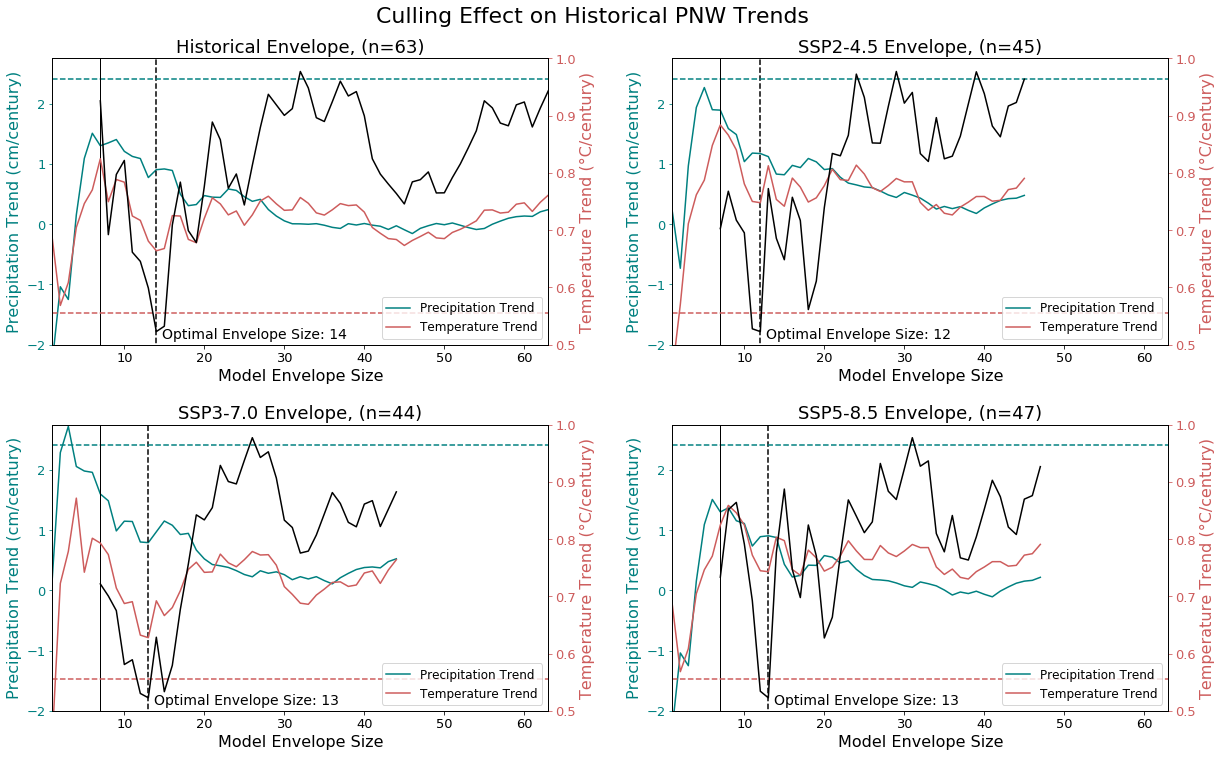

In [126]:
# Will add observed values once more observational datasets are included
# Current obs trends highly questionable
expsplot = {}
expsplot['hist'] = 'Historical'
expsplot['ssp245'] = 'SSP2-4.5'
expsplot['ssp370'] = 'SSP3-7.0'
expsplot['ssp585'] = 'SSP5-8.5'
colores = {}
colores['hist'] = 'k'
colores['ssp245'] = 'blue'
colores['ssp370'] = 'orange'
colores['ssp585'] = 'green'

pcol = 'teal'
tcol = 'indianred'
fig,axs = plt.subplots(2,2,figsize=(20,12))
i=0
for ax in axs.flat:
    exp=exps[i]
    ax1 = ax
    plt.sca(ax)
    nmodexp = len(modlist[exp])
    #ax1 = plt.subplot()
    l1, = ax1.plot(np.arange(1,nmodexp+1),pthist_subset[exp],color=pcol)
    ax1.plot([mintot[exp],mintot[exp]],[-2.5,2.75],'--k')
    #ax1.plot([17,17],[min(pthist)-.1,max(pthist)+.1],'--k')
    ax1.plot([1,nmod+1],[pptrendo,pptrendo],'--',color=pcol)
    ax1.set_ylim(-2.0,2.75)
    ax1.set_ylabel('Precipitation Trend (cm/century)',color=pcol,fontsize=16)
    ax2 = ax1.twinx()
    l2, = ax2.plot(np.arange(1,nmodexp+1),tthist_subset[exp],color=tcol)
    ax2.plot([1,nmod+1],[pttrendo,pttrendo],'--',color=tcol)
    ax2.set_ylabel('Temperature Trend (°C/century)',color=tcol,fontsize=16)
    ax2.set_ylim(0.5,1)
    
    ax3 = ax1.twinx()
    l3, = ax3.plot(np.arange(1,nmodexp+1),errtot[exp],color='k')
    ax3.set_yticks([])
    ax1.plot([7,7],[-2.5,2.75],'-k',linewidth=1.)
    
    plt.xlim([1,nmod])
    ax1.text(mintot[exp]+0.7,-1.9,'Optimal Envelope Size: '+str(mintot[exp]),fontsize=14)
    ax1.set_xlabel('Model Envelope Size',fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax1.tick_params(axis='y', which='major', colors=pcol)
    ax2.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='y', which='major', colors=tcol)
    plt.legend([l1, l2], ["Precipitation Trend", "Temperature Trend"],loc='lower right',fontsize=12)
    plt.title(expsplot[exp] +' Envelope, (n='+str(nmodexp)+')',fontsize=18)
    plt.suptitle('Culling Effect on Historical PNW Trends',fontsize=22,y=.94)
    fig.subplots_adjust(left=0.125,right=0.9,wspace=0.25,hspace=0.28)
    i+=1
plt.savefig('/glade/u/home/nlybarger/CMIP6_1900-2014.global-PNW.Historical_cullingTrend.png',dpi=450,bbox_inches='tight',facecolor='w')

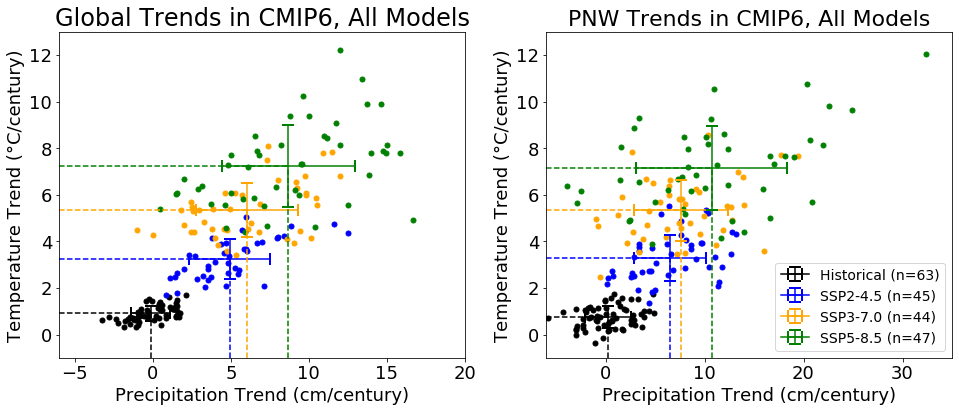

In [131]:
# Something is wrong with the trends in these models for this experiment
global_ptrends['ssp245'][[14,18,32,40]] = np.nan
global_ttrends['ssp245'][[14,18,32,40]] = np.nan

# Plot Global and PNW trends for all CMIP6 experiments studied

fig,axes=plt.subplots(1,2,figsize=(16,6))
plt.sca(axes[0])
for exp in exps:
    tmean = np.nanmean(global_ttrends[exp])
    pmean = np.nanmean(global_ptrends[exp])
    terr = np.nanstd(global_ttrends[exp])
    perr = np.nanstd(global_ptrends[exp])
    n = np.count_nonzero(~np.isnan(global_ttrends[exp]))
    for i in range(len(global_ttrends[exp])):
        plt.scatter(global_ptrends[exp][i],global_ttrends[exp][i],color=colores[exp],s=25)
    plt.plot([-6,pmean],[tmean, tmean],linestyle='--',color=colores[exp])
    plt.plot([pmean,pmean],[-1,tmean],linestyle='--',color=colores[exp])
    plt.errorbar(pmean,tmean,xerr=perr,yerr=terr,color=colores[exp],capsize=6,capthick=2,label = (expsplot[exp] + ' (n=' + str(n) + ')'))
plt.xlim(-6,20)
plt.xlabel('Precipitation Trend (cm/century)',fontsize=18)
plt.ylim(-1,13.)
plt.ylabel('Temperature Trend (°C/century)',fontsize=18)
plt.title('Global Trends in CMIP6, All Models',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.sca(axes[1])
for exp in exps:
    tmean = np.nanmean(pnw_ttrends[exp])
    pmean = np.nanmean(pnw_ptrends[exp])
    terr = np.nanstd(pnw_ttrends[exp])
    perr = np.nanstd(pnw_ptrends[exp])
    n = np.count_nonzero(~np.isnan(pnw_ttrends[exp]))
    for i in range(len(pnw_ttrends[exp])):
        plt.scatter(pnw_ptrends[exp][i],pnw_ttrends[exp][i],color=colores[exp],s=25)
    plt.plot([-6,pmean],[tmean, tmean],linestyle='--',color=colores[exp])
    plt.plot([pmean,pmean],[-1,tmean],linestyle='--',color=colores[exp])
    plt.errorbar(pmean,tmean,xerr=perr,yerr=terr,color=colores[exp],capsize=6,capthick=2,label = (expsplot[exp] + ' (n=' + str(n) + ')'))
plt.legend(fontsize=14)
plt.xlim(-6,35)
plt.xlabel('Precipitation Trend (cm/century)',fontsize=18)
plt.ylim(-1,13.)
plt.ylabel('Temperature Trend (°C/century)',fontsize=18)
plt.title('PNW Trends in CMIP6, All Models',fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('/glade/u/home/nlybarger/CMIP6_1901-2014.global-PNW.allSSP_PTtrends.png',dpi=450,bbox_inches='tight',facecolor='w')

3.5937439218614733
0.9948888971226351
ssp245 15
3.6168870232354404
0.5938620770528265
4.776800444169871
1.308959079027744
ssp370 19
5.0387321258186635
0.977563918491245
7.6085894020933615
1.805804842006613
ssp585 15
6.78385093341199
1.101918334271375


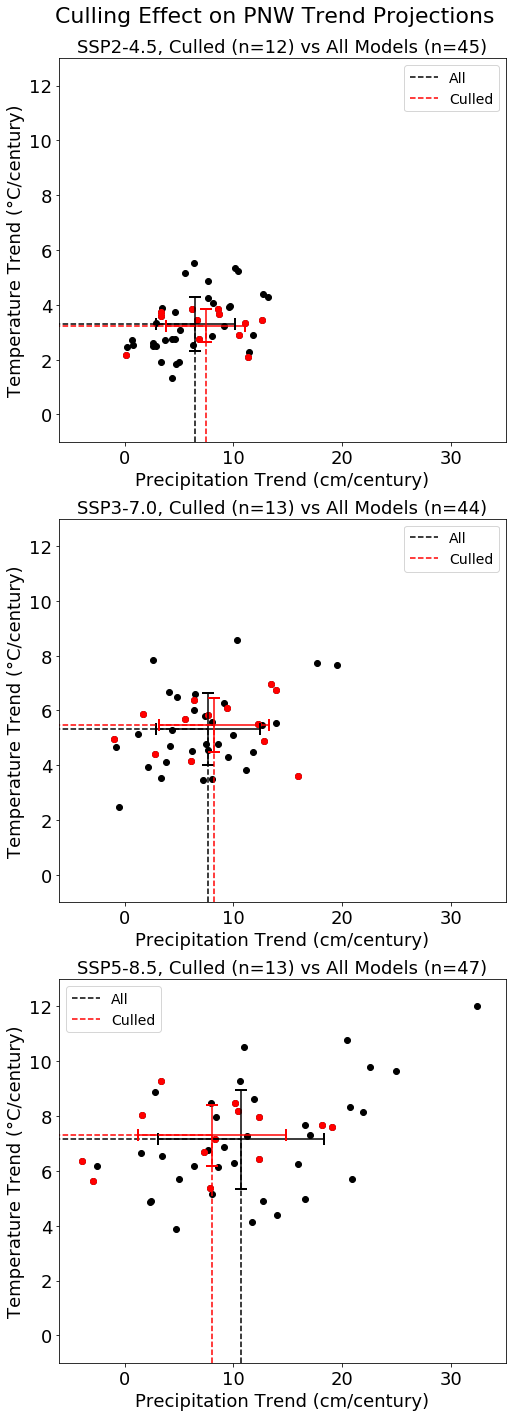

In [86]:
# Plot SSP trend projections for all models and only the culled envelope

fig,axes = plt.subplots(3,1,figsize=(8,24))
i=1
w=0
l=1
for ax in axes.flat:
    plt.sca(ax)
    exp = exps[l]
    t = pnw_ttrends[exp]
    tmean = np.nanmean(t)
    p = pnw_ptrends[exp]
    pmean = np.nanmean(p)
    perr = np.nanstd(p)
    terr = np.nanstd(t)
    print(perr)
    print(terr)
    for j in range(nmod):
        plt.scatter(p[j],t[j],color='k')
    plt.plot([-12,pmean],[tmean, tmean],'--k',label='All')
    plt.plot([pmean,pmean],[-1,tmean],'--k')
    plt.errorbar(pmean,tmean,xerr=perr,yerr=terr,color='k',capsize=6,capthick=2)

    nmodexp = len(modlist[exp])
    k = mintot[exp]
    
    while np.count_nonzero(~np.isnan(pnw_ptrends[exp][0:k])) <= mintot[exp]-1:
        k+=1
    print(exp + ' ' + str(k))
    t = pnw_ttrends[exp][:k]
    tmean = np.nanmean(t)
    p = pnw_ptrends[exp][:k]
    pmean = np.nanmean(p)
    perr = np.nanstd(p)
    terr = np.nanstd(t)
    print(perr)
    print(terr)
    for j in range(k):
        plt.scatter(p[j],t[j],color='r')
    plt.plot([-12,pmean],[tmean, tmean],'--r',label='Culled')
    plt.plot([pmean,pmean],[-1,tmean],'--r')
    plt.errorbar(pmean,tmean,xerr=perr,yerr=terr,color='r',capsize=6,capthick=2)
    plt.xlim(-6,35)
    plt.xlabel('Precipitation Trend (cm/century)',fontsize=18)
    plt.ylim(-1,13.)
    plt.ylabel('Temperature Trend (°C/century)',fontsize=18)
    plt.title(expsplot[exp]+ ', Culled (n=' + str(mintot[exp]) + ') vs All Models (n=' + str(nmodexp) +')',fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=18)
    l+=1
    w+=1
plt.suptitle('Culling Effect on PNW Trend Projections',fontsize=22,y=.91)
plt.savefig(diro + 'CMIP6_1901-2014.allSSP.projenv_culled.png',dpi=450,bbox_inches='tight',facecolor='w')